# Plot radial analysis

This notebook counts the cumulative spatio-temporal distribution of cellular events in the local neighbourhood of a series of focal events and renders various types of plots to show distributions etc


In [1]:
import calculate_radial_analysis as calculate
import dataio

import glob
import os
import re
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from natsort import natsorted
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
def render(N_events_df, N_cells_df, bins, t_range, R_max):
    """
    Take 2 input dataframes of events and cell apperances and render a ratio plot of the two according to the provided params
    
    N_events_df : pd.DataFrame
        Dataframe showing the cumulative spatiotemporal distribution of cellular events around a series of 
        focal events. For example, the distributions of divisions around focal apoptoses.
        
    N_cells_df : pd.DataFrame
        Corresponding dataframe showing the cumulative spatiotemporal distribution of cells around a series of focal events.
    
    bins : int or tuple
        How to plot the provided data in a 2d histogram. If int then symmetric histogram is plotted.
    
    t_range : int
        Maximum extent of the x axis of the histogram
    
    R_max : int
        Maximum extent of the y axis of the histogram
    
    """
    
    t_min = min(t_range)
    t_max = max(t_range)
    N_events_constrained_df = N_events_df.loc[(N_events_df['Time since apoptosis'] >= t_min) & (N_events_df['Time since apoptosis'] <= t_max) & (N_events_df['Distance from apoptosis'] <= R_max)]
    N_cells_constrained_df = N_cells_df.loc[(N_cells_df['Time since apoptosis'] >= t_min) & (N_cells_df['Time since apoptosis'] <= t_max) & (N_cells_df['Distance from apoptosis'] <= R_max)]

    N_events, xedges, yedges, _ = plt.hist2d(N_events_constrained_df['Time since apoptosis'], N_events_constrained_df['Distance from apoptosis'],
                      bins=bins, cmap='Blues')
    plt.clf()
    N_cells, xedges, yedges, _ = plt.hist2d(N_cells_constrained_df['Time since apoptosis'], N_cells_constrained_df['Distance from apoptosis'],
                      bins=bins, cmap='Blues')
    plt.clf()
    
    P_events = N_events/N_cells
    
    return P_events, xedges, yedges, N_events, N_cells

def load_radial_df(file_list, limit = None, crop_amount = 20, streamline = True, strict_filtering = False):
    """
    Function to load and compile a series of radial scans into a larger cumulative dataframe.
    Can provide various criterion to filter the data sets by. 
    I'm sure this code is messy in the latter parts but i do not have time to tidy rn!!!!!!
    
    file_list : list of paths
        List of full paths to the .csv files containing the focal scan results
        
    limit : int or tuple 
        int of maximum scan radius or tuple of (maximum scan radius, minimum scan duration (frames))
        If int then it defines the maximum radius of a focal scan in pixels, if this radius leaves the field of view 
        then that focal apoptosis is either a) excluded from the cumulative scan (if strict_filtering == True)
        or b) The time points at which is leaves the FOV are excluded (if R is given but strict_filtering == False).
        If tuple then the second value is the minimum time period of any included focal scan. Need to include

    crop_amount : int
        Defines the cropping amount necessary to exclude boundary effect cells/divisions from
        the radial scan

    streamlined : bool
        If True this returns just the distance from apoptosis and time since apoptosis variables 
        in the data frame. If False then it returns data frame as in the .csv file.
        
    strict_filtering : bool
        If True then this means that any focal scans that do not meet the inclusion criteria stipulated in `limit`
        will be entirely dismissed, rather than individual timepoints being dismissed. 
    """
    radial_scan_df = []
    N_focal_cells = 0

    ### if limit is not provided then do not filter any focal apoptoses
    if not limit:
        R = 0
    ### if limit is a tuple then filter according to a maximum radius staying within the fov and a minimum focal scan length
    if type(limit) == tuple:
        T = limit[1] 
        R = limit[0] 
    else:
        T = None
        R = limit
    
    ### define window within which focal cell can exist if there is a spatial limit
    x_range = range(R, 1200 - R)
    y_range = range(R, 1600 - R)    
    
    ### iterate over each individual scan and compile into cumulative pd dataframe    
    for file in tqdm(file_list):
        ### first check to see if focal cell meets inclusion criterion
        if R > 0:
            ### get apoptosis time
            focal_t = int(re.search('txy_(\d+)', file).group(1))
            ### get apop id to load apop xyt file
            apop_ID = file.split('/')[-1].split('_N_')[0]
            ### ensure correct cell type
            if 'Scr' in apop_ID:
                apop_ID = apop_ID.replace('Scr_-','')+'_RFP'
            if 'wt' in apop_ID:
                apop_ID = apop_ID.replace('wt_','')+'_GFP'
            ### load full apo xyt ### need to change this path if im using the typical randomised control
            apo_xyt_fn = os.path.join('/home/nathan/data/kraken/scr/h2b/giulia/experiment_information/apoptoses/apoptotic_tracks/',#', #control_event_tracks
                                     f'{apop_ID}.csv')
            ### load focal cell information
            apo_df = pd.read_csv(apo_xyt_fn)
            ### remove unnecessary index column
            del apo_df['Unnamed: 0']
            ### see if any of the frames of the focal cell leave the FOV
            frames_outside_fov = []
            for apo_x, apo_y, apo_t in zip(apo_df['x'], apo_df['y'], apo_df['t']):
                if int(apo_x) not in x_range or int(apo_y) not in  y_range:
                    frames_outside_fov.append(apo_t)
            ### if filtering is strict then exclude any focal cell that leves fov
            if strict_filtering == True:
                if len(frames_outside_fov) > 0:
                    continue
                ### if filtering is strict and there are no frames outside of the fov then exclude if temporal criterion isnt met
                elif T:
                    if focal_t - min(apo_df['t']) < T:
                        continue
        ### if filtering is present but not strict then just exclude time points outside fov
        apo_t, apo_x, apo_y = [int(re.search('txy_(\d+)_(\d+)_(\d+)', file)[i]) for i in range(1,4)]
        ### load dataframe
        df = pd.read_csv(file, names = ['Cell ID', 'Distance from apoptosis', 'Frame', 'x', 'y'])
        ### tidy up dataframe
        df['Cell ID'] = df['Cell ID'].str.replace('[()]', '')
        df['y'] = df['y'].str.replace('[()]', '')
        df = df.astype(int)
        ### normalise time
        df['Time since apoptosis'] = df['Frame'] - apo_t
        ### eliminate boundary counts spatially
        df = df.loc[(df['x'] >= crop_amount) & (df['x'] <= 1200-crop_amount) & (df['y'] >= crop_amount) & (df['y'] <= 1600-crop_amount)]
        ### eliminate boundary effects temporally (ie. if scan exits fov at any time point) by deleting those frames from the scan
        if R > 0: 
            df = df[~df['Frame'].isin(frames_outside_fov)]
        ### remove unnecessary data
        if streamline:
            del df['x'], df['y'], df['Cell ID'], df['Frame']
        radial_scan_df.append(df)
        N_focal_cells +=1
    radial_scan_df = pd.concat(radial_scan_df, axis = 0, ignore_index = True)
    radial_scan_df['Time since apoptosis'] = radial_scan_df['Time since apoptosis']*(4/60)
    radial_scan_df['Distance from apoptosis'] = radial_scan_df['Distance from apoptosis']/3
    print('Number of focal cells included in cumulative scan:', N_focal_cells)
    
    return radial_scan_df

# Compile individual scans into cumulative dataframes 

In [3]:
scan_dir = f'/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600'

In [4]:
files = natsorted(glob.glob(f'{scan_dir}/*.csv'))
event_files = [file for file in files if 'N_events' in file]

In [5]:
event_files

['/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-6_N_events_wt_rad_1600_t_range_1600_focal_txy_469_692_922.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-70_N_events_wt_rad_1600_t_range_1600_focal_txy_820_1086_1043.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-73_N_events_wt_rad_1600_t_range_1600_focal_txy_773_1123_1247.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-283_N_events_wt_rad_1600_t_range_1600_focal_txy_913_1085_289.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-298_N_events_wt_rad_1600_t_range_1600_focal_txy_568_404_1103.csv',
 '/home/nathan/data/results/radial_analysis

### Additional params stipulate whether to filter focal scans

In [175]:
N_events_df = load_radial_df(event_files,#) ## no filtering 
                                    limit = (150, 150),
                             crop_amount = 20, ### how much to crop the spatial measurements to avoid boundary effects
                             streamline = False, 
                            strict_filtering=True)

  0%|          | 0/1839 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 598


In [7]:
N_events_df

,Cell ID,Distance from apoptosis,Frame,x,y,Time since apoptosis
0,23,124.666667,322,569,1311,-9.800000
1,22,122.666667,576,420,673,7.133333
2,21,79.666667,371,486,784,-6.533333
3,20,315.000000,324,391,46,-9.666667
4,19,134.333333,376,416,622,-6.200000
...,...,...,...,...,...,...
147919,1262,154.666667,1036,949,1504,3.533333
147920,1276,272.000000,967,20,1157,-1.066667
147921,1313,109.000000,1033,1107,878,3.333333
147922,1393,235.333333,990,340,1563,0.466667


### Loading cell counts for probability plot

Has to be streamlined for full list

In [8]:
cell_count_files = [file for file in files if 'N_cell' in file]

In [9]:
cell_count_files

['/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-6_N_cells_wt_rad_1600_t_range_1600_focal_txy_469_692_922.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-70_N_cells_wt_rad_1600_t_range_1600_focal_txy_820_1086_1043.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-73_N_cells_wt_rad_1600_t_range_1600_focal_txy_773_1123_1247.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-283_N_cells_wt_rad_1600_t_range_1600_focal_txy_913_1085_289.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-298_N_cells_wt_rad_1600_t_range_1600_focal_txy_568_404_1103.csv',
 '/home/nathan/data/results/radial_analysis_outp

In [10]:
N_cells_df = load_radial_df(cell_count_files,# ) #no filtering
                                    limit = (150, 150),
                             crop_amount = 20, ### how much to crop the spatial measurements to avoid boundary effects
                             streamline = False, 
                            strict_filtering=True)

  0%|          | 0/1839 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 598


In [11]:
N_cells_df

,Cell ID,Distance from apoptosis,Frame,x,y,Time since apoptosis
0,2,359.666667,0,170,69,-31.266667
1,1,358.666667,0,203,50,-31.266667
2,23,157.666667,0,575,1353,-31.266667
3,22,103.333333,0,536,790,-31.266667
4,21,110.333333,0,537,748,-31.266667
...,...,...,...,...,...,...
107658607,2156,329.000000,1039,841,68,3.733333
107658608,2160,269.333333,1039,76,768,3.733333
107658609,2161,292.666667,1039,603,207,3.733333
107658610,2163,400.666667,1039,155,62,3.733333


# Plotting the spatiotemporal distribution ratio of events to appearances 

`P_events = N_events/N_cells`

Text(0.5, 0, 'Time since apoptoses (hours)')

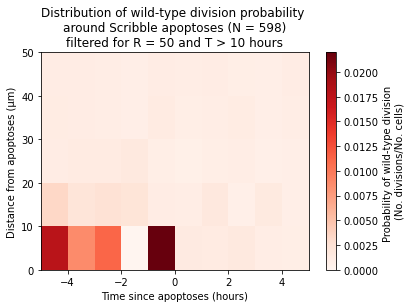

In [12]:
t_range = (-5,5)
R_max = 50
bins = (10, 5)
P_events, xedges, yedges, N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Reds', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 598)\nfiltered for R = 50 and T > 10 hours')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('', bbox_inches = 'tight')

# my version of figure 2C of the paper

#### pre apoptosis

Text(0.5, 0, 'Time since apoptoses (hours)')

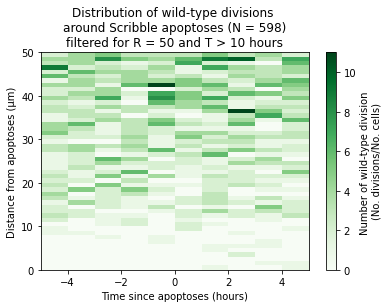

In [17]:
t_range = (-5,5)
R_max = 50
bins = (10, 50)
P_events, xedges, yedges, N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, N_events.T, cmap = 'Greens', )
plt.colorbar(label = 'Number of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type divisions \naround Scribble apoptoses (N = 598)\nfiltered for R = 50 and T > 10 hours')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

#plt.savefig('', bbox_inches = 'tight')

#### post apoptosis

Text(0.5, 0, 'Time since apoptoses (hours)')

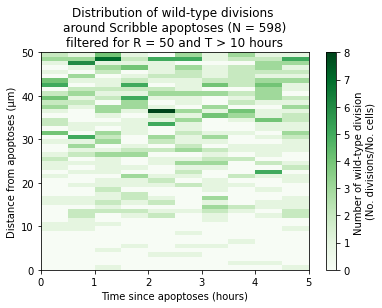

In [19]:
t_range = (0,5)
R_max = 50
bins = (10, 50)
P_events, xedges, yedges, N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, N_events.T, cmap = 'Greens', )
plt.colorbar(label = 'Number of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type divisions \naround Scribble apoptoses (N = 598)\nfiltered for R = 50 and T > 10 hours')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

### needs to be density ie. divide by area ~and time~?

"Distances in time and space between all couples of extrusions were computed. For each data set we plotted the maps of densities of death at a given distance (number of deaths divided by the area of the disc considered)"

As it is for one movie, to get a comparable rate I divide by the number of scans this data is sampled from (N)

Text(0.5, 0, 'Time since apoptoses (hours)')

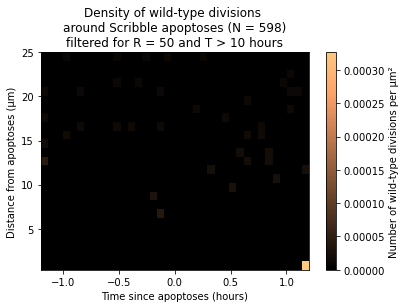

In [350]:
N = 598
t_range = (-1.25, 1.25)# (-2.5,2.5)
R_max = 25
bins = (int((t_range[1]-t_range[0])*60/4),R_max)
P_events, xedges, yedges, N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
### density calc
ring_areas = [((np.pi * R**2 ) - (np.pi * yedges[i-1]**2 )) for i, R in enumerate(yedges) if i != 0]  
N_events_density = N_events / [area * N for area in ring_areas]#(ring_areas * 598)

pc = plt.pcolormesh(xedges, yedges, N_events_density.T, cmap = 'copper', )
plt.colorbar(label = 'Number of wild-type divisions per µm²',)
plt.title('Density of wild-type divisions \naround Scribble apoptoses (N = 598)\nfiltered for R = 50 and T > 10 hours')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('', bbox_inches = 'tight')

Text(0.5, 0, 'Time since apoptoses (hours)')

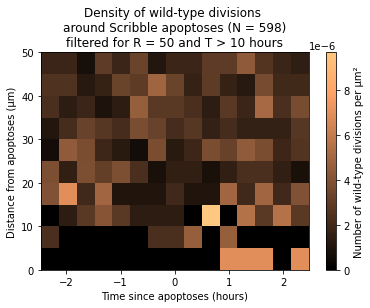

In [354]:
N = 1839
t_range =(-2.5,2.5)
R_max = 50
bins = (15,10) #(int(((t_range[1]-t_range[0])*60/4)/2),int(R_max/2))
P_events, xedges, yedges, N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
### density calc
ring_areas = [((np.pi * R**2 ) - (np.pi * yedges[i-1]**2 )) for i, R in enumerate(yedges) if i != 0]  
N_events_density = N_events / [area * N for area in ring_areas]#(ring_areas * 598)

pc = plt.pcolormesh(xedges, yedges, N_events_density.T, cmap = 'copper', )
plt.colorbar(label = 'Number of wild-type divisions per µm²', )
plt.title('Density of wild-type divisions \naround Scribble apoptoses (N = 598)\nfiltered for R = 50 and T > 10 hours')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

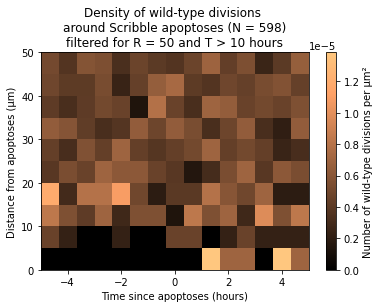

In [356]:
N = 1839
t_range =(-5,5)
R_max = 50
bins = (15,10) #(int(((t_range[1]-t_range[0])*60/4)/2),int(R_max/2))
P_events, xedges, yedges, N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
### density calc
ring_areas = [((np.pi * R**2 ) - (np.pi * yedges[i-1]**2 )) for i, R in enumerate(yedges) if i != 0]  
N_events_density = N_events / [area * N for area in ring_areas]#(ring_areas * 598)

pc = plt.pcolormesh(xedges, yedges, N_events_density.T, cmap = 'copper', )
plt.colorbar(label = 'Number of wild-type divisions per µm²', )
plt.title('Density of wild-type divisions \naround Scribble apoptoses (N = 598)\nfiltered for R = 50 and T > 10 hours')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

#### Unfiltered focal apoptoses

Text(0.5, 0, 'Time since apoptoses (hours)')

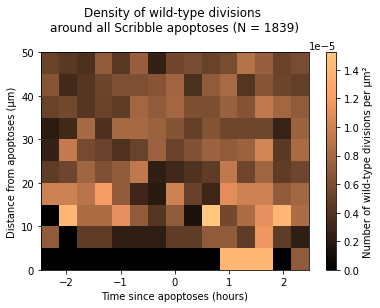

In [357]:
N = 1839
t_range =(-2.5,2.5)
R_max = 50
bins = (15,10) #(int(((t_range[1]-t_range[0])*60/4)/2),int(R_max/2))
P_events, xedges, yedges, N_events, N_cells = render(N_events_df_all, N_cells_df, bins, t_range, R_max)
### density calc
ring_areas = [((np.pi * R**2 ) - (np.pi * yedges[i-1]**2 )) for i, R in enumerate(yedges) if i != 0]  
N_events_density = N_events / [area * N for area in ring_areas]#(ring_areas * 598)

pc = plt.pcolormesh(xedges, yedges, N_events_density.T, cmap = 'copper', )
plt.colorbar(label = 'Number of wild-type divisions per µm²', )
plt.title('Density of wild-type divisions \naround all Scribble apoptoses (N = 1839)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

The apparent proximo-distal gradient is driven by border
effects: for large radius search, a significant amount of area is outside the death search window, hence reducing the number of
deaths events per unit of space. This explains the apparent low densities at high distance both in experiments and simulations.

Text(0.5, 0, 'Time since apoptoses (hours)')

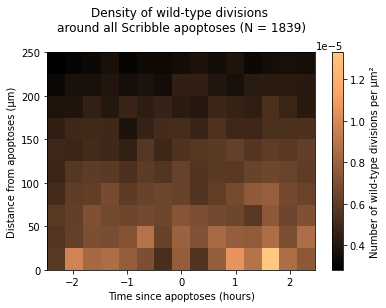

In [360]:
N = 1839
t_range =(-2.5,2.5)
R_max = 250
bins = (15,10) #(int(((t_range[1]-t_range[0])*60/4)/2),int(R_max/2))
P_events, xedges, yedges, N_events, N_cells = render(N_events_df_all, N_cells_df, bins, t_range, R_max)
### density calc
ring_areas = [((np.pi * R**2 ) - (np.pi * yedges[i-1]**2 )) for i, R in enumerate(yedges) if i != 0]  
N_events_density = N_events / [area * N for area in ring_areas]#(ring_areas * 598)

pc = plt.pcolormesh(xedges, yedges, N_events_density.T, cmap = 'copper', )
plt.colorbar(label = 'Number of wild-type divisions per µm²', )
plt.title('Density of wild-type divisions \naround all Scribble apoptoses (N = 1839)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

# Poisson simulation of rate of wild-type division

From each data set we estimated the effective death rate, i.e. the intensity of the random spatio-temporal
process, and used it to simulate the corresponding Poisson process 200 times. For each simulation we performed the same analysis
as for the experimental data set, namely calculating maps of death densities, and eventually averaged the 200 maps.



#### For the analytic calculation of the cumulative probability of a Poisson process, we consider p, the probability of death of one cell inside a time window of T minutes, given by:

(See other K_function analysis exploration notebook for calculation of lambda_d)

In [562]:
lambda_d = 0.11875927536617979 #### instrinsic rate of division per minute

### Calculation of the intrinsic death intensity with continuous time and space

Assume that X is the spatiotemporal Poission process. Then, by definition the probability that the number of events that fall in the spatial region C during that time period [0,t] is equal to k is: 

P{N([0,t] x C) = k} = ((lambda.t.a(C))^^k / k!) exp(-lambda.t.a(C))

Hence (see physical notebook) is k = 0 and no event happens the probability is exp(-lambda.t.pi.r^^2) ie the survival function.

By definition of the space-time intensity of the process, the probability that the event happens in a given moment t and that it falls on
a position (x,y), is given by:

p = lambda·dt·dx·dy

Now considering the self-inhibiting spatiotemporal process, meaning for each event there is a feedback that inhibits the process on a disk around the event of radius r and during period t. Such a process is not Poisson, but can be approx as one with a differente effective intensity lambda_e. The probability that death happens as some time and lcoation (t,x,y) is the probabnility that there was no event in its spatiotemporal vicinity multiplied by the probability of an **isolated** cell death at this moment. So



#### Probability of not dividing

i.e. the probability of surviving dividing

Text(0.5, 1.0, 'Probability of not dividing')

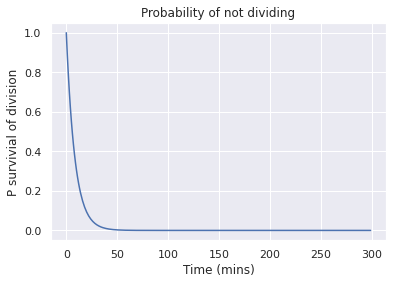

In [564]:
T = np.arange(0,50)
plt.plot(np.exp(-lambda_d * T))
plt.ylabel('P survivial of division')
plt.xlabel('Time (mins)')
plt.title('Probability of not dividing')

Text(0.5, 1.0, 'Probability of not dividing')

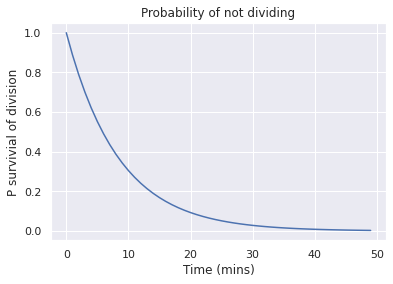

In [594]:
T = np.arange(0,50)
plt.plot(np.exp(-lambda_d * T))
plt.ylabel('P survivial of division')
plt.xlabel('Time (mins)')
plt.title('Probability of not dividing')

#### Probability of dividing 

i.e. the probability of not surviving dividing

Text(0.5, 1.0, 'Probability density function of dividing')

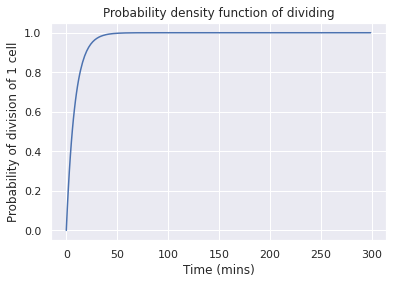

In [568]:
plt.plot(1-np.exp(-lambda_d * T))
plt.ylabel('Probability of division of 1 cell')
plt.xlabel('Time (mins)')
plt.title('Probability density function of dividing')

#### Cumulative density function of dividing

i.e. P(T<=t), probability that there will be a division at t or any point up until t. 

Text(0.5, 0, 'Time (mins)')

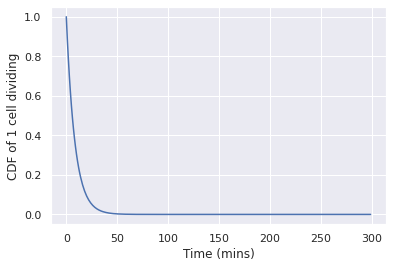

In [566]:
plt.plot(1-(1-np.exp(-lambda_d * T)))
plt.ylabel('CDF of 1 cell dividing')
plt.xlabel('Time (mins)')

#### Cumulative density function of N cells dividing

Text(0.5, 0, 'Time (mins)')

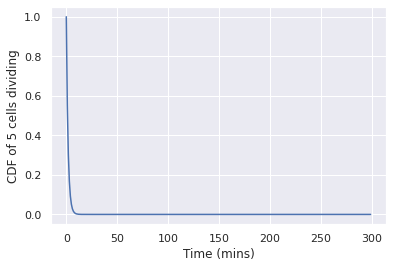

In [569]:
plt.plot((1-(1-np.exp(-lambda_d * T)))**5)
plt.ylabel('CDF of 5 cells dividing')
plt.xlabel('Time (mins)')

### Cumulative density function that NO cells divide a distance x from focal point can be expressed as 

`1 - (1 - p)**cx**2`

where `p = (1-np.exp(-lambda_d * T))`

This expression can be further developed into 

`Fx = 1 - np.exp(-lambda_d * T * c * x**2)` 

where `c*x**2` is the number of cells in a disk of radius x. Swapping out lambda_d for lambda_c, the intrinsic rate per minute per unit of surface leaves us with

In [640]:
lambda_c = 1.6373688047283523e-07 #Instrinsic rate of division per min and per unit surface area (um2)
range_ = 500
x = np.arange(0,range_) # distance from division
T = np.arange(0,range_)

In [641]:
Fx = 1 - np.exp(-lambda_c * np.pi * T * x)

In [642]:
cumulative = np.zeros((range_,range_))
x = np.arange(0,range_)
T = np.arange(0,range_)
for i in T:
    for j in x:
        cumulative[i,j] = 1 - np.exp(-lambda_c * np.pi * i * j)

Text(0.5, 0, 'Time since apoptoses (mins)')

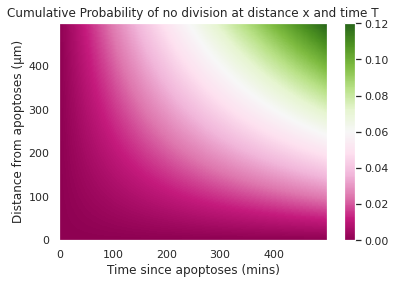

In [645]:
pc = plt.pcolormesh(T, x, cumulative, cmap = 'PiYG', )
plt.colorbar()#label = 'Number of wild-type divisions per µm²', )
plt.title('Cumulative Probability of no division at distance x and time T')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (mins)')

Text(0.5, 0, 'Time since apoptoses (mins)')

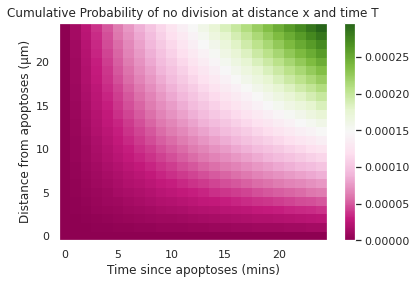

In [646]:
cumulative = np.zeros((25,25))
x = np.arange(0,25)
T = np.arange(0,25)
for i in T:
    for j in x:
        cumulative[i,j] = 1 - np.exp(-lambda_c * np.pi * i * j)
pc = plt.pcolormesh(T, x, cumulative, cmap = 'PiYG', )
plt.colorbar()#label = 'Number of wild-type divisions per µm²', )
plt.title('Cumulative Probability of no division at distance x and time T')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (mins)')

Text(0.5, 0, 'Time since apoptoses (mins)')

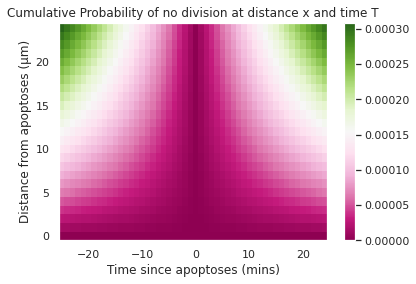

In [647]:
cumulative = np.zeros((50,25))
x = np.arange(0,25)
T = np.arange(-25,25)
for i in T:
    for j in x:
        cumulative[i+25,j] = 1 - np.exp(-lambda_c * np.pi * abs(i) * j)
pc = plt.pcolormesh(T, x, cumulative.T, cmap = 'PiYG', )
plt.colorbar()#label = 'Number of wild-type divisions per µm²', )
plt.title('Cumulative Probability of no division at distance x and time T')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (mins)')

# Major q: should lambda_c/d be variable in time and space?

I.e. should the rate of division be constant or dependent on time and distance since apoptosis?

# p_values test using "K-functions" and random labeLLing test

This procedure is used for estimating how far is one spatio-temporal process from a purely random Poisson process (Smith, 2020).
The test is performed in two main steps. The first step consists of calculating so-called "K-functions" of the given process, and the
second is the random re-labeling test as explained below

The space-time K-function of the observed process, K0(r,h), is defined as the expected number of additional events within the
space-time distance r,h of a randomly selected event. It depends on the intensity lambda of the spatio-temporal process and it can
be estimated using only the observed events and without additional assumption on the process.
The complete absence of dispersion or clustering in a given process implies that there is no relation between the location and
timing of events. This is formally given through the temporal indistinguishability hypothesis. Under this hypothesis, there is an equal
probability to observe our set of events,

#### Drawing a sample of N random permutations of the times of events

In [652]:
N_events_df['Time since apoptosis'].sample(n=100)

131464   -20.666667
56061      2.533333
111541    -7.133333
103860    32.733333
3588      -2.200000
            ...    
10060     -4.733333
21368      3.866667
65253     -1.600000
77177    -33.600000
115427    -7.400000
Name: Time since apoptosis, Length: 100, dtype: float64

#### Calculate the K-function for each permutation

# Closest death analysis

"To confirm this
bias and to quantitatively determine the characteristics of this
feedback on cell death, we used a closest-neighbor analysis
(Figure 2G): for every cell elimination, "

Need to filter dataframe for <150um away to ensure all mitoses within scan radius stipulated by focal filtering

In [158]:
N_events_df

,Cell ID,Distance from apoptosis,Frame,x,y,Time since apoptosis
0,23,124.666667,322,569,1311,-9.800000
1,22,122.666667,576,420,673,7.133333
2,21,79.666667,371,486,784,-6.533333
3,20,315.000000,324,391,46,-9.666667
4,19,134.333333,376,416,622,-6.200000
...,...,...,...,...,...,...
147919,1262,154.666667,1036,949,1504,3.533333
147920,1276,272.000000,967,20,1157,-1.066667
147921,1313,109.000000,1033,1107,878,3.333333
147922,1393,235.333333,990,340,1563,0.466667


In [210]:
step = 1 ## difference between temporal bins to plot distance of mitoses from apops
temporal_binned = {}
for time_bin in [(i, i+step) for i in np.arange(t_range[0], t_range[1], step)]:
    temporal_binned[time_bin] = N_events_df.loc[(N_events_df['Time since apoptosis'] >= time_bin[0]) & (N_events_df['Time since apoptosis'] <= time_bin[1])]

Text(0, 0.5, 'integrated division probability')

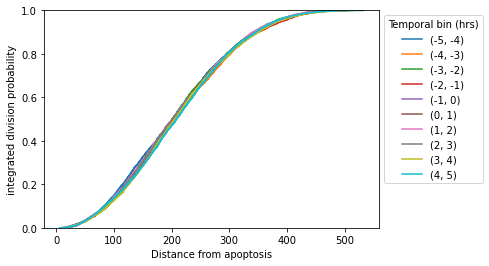

In [281]:
for i in temporal_binned:
    ecdf = sns.ecdfplot(data=temporal_binned[i]['Distance from apoptosis'], label = i)
plt.legend(labels=temporal_binned, title = 'Temporal bin (hrs)', loc = 2,bbox_to_anchor = (1,1))
plt.ylabel('integrated division probability')

##### Plotting ecdf for set values of x

In [217]:
lines = [obj for obj in ecdf.findobj() if str(type(obj)) == "<class 'matplotlib.lines.Line2D'>"]

In [222]:
x, y = lines[0].get_data()[0], lines[0].get_data()[1]

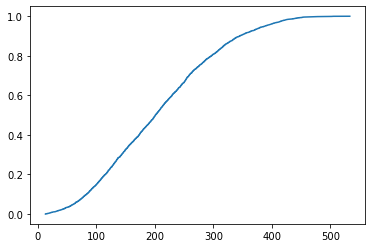

In [223]:
plt.plot(x, y)

In [235]:
### y when x is 100 
y_when_x_100 = [i[1] for n, i in enumerate(zip(x, y)) if i[0] == 100]
y_when_x_100

[0.14802532408803135,
 0.14832680132649986,
 0.14862827856496835,
 0.14892975580343684,
 0.14923123304190533]

In [262]:
y_vals = [i[1] for n, i in enumerate(zip(x, y)) if i[0] == 100]
y_vals

[0.14018691588785046, 0.14048839312631897, 0.14078987036478746]

In [272]:
y_when_x_100 = pd.DataFrame()
for n, t_bin in enumerate(temporal_binned):
    x, y = lines[n].get_data()[0], lines[0].get_data()[1]

    y_vals = [i[1] for n, i in enumerate(zip(x, y)) if i[0] == 100]
    y_when_x_100[t_bin] = pd.Series(y_vals)
#     if len(y_vals) < 5:
#         y_vals = np.pad(y_vals, (5-len(y_vals),), 'constant', constant_values = np.nan)    
#     y_when_x_100[t_bin] = y_vals

In [273]:
y_when_x_100

,"(-5, -4)","(-4, -3)","(-3, -2)","(-2, -1)","(-1, 0)","(0, 1)","(1, 2)","(2, 3)","(3, 4)","(4, 5)"
0,0.148025,0.140187,0.144408,0.149834,0.154055,0.145915,0.153150,0.144709,0.132349,0.139885
1,0.148327,0.140488,0.144709,0.150136,0.154356,0.146216,0.153452,0.145011,0.132650,0.140187
2,0.148628,0.140790,NaN,0.150437,NaN,NaN,0.153753,NaN,0.132951,0.140488
3,0.148930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.140790
4,0.149231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.141091


Text(-5.950000000000003, 0.5, 'integrated division probability at distance 100um')

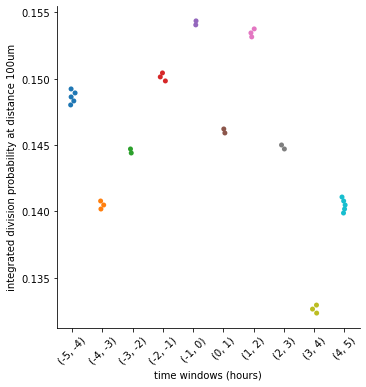

In [282]:
sns.catplot(data=y_when_x_100,)
plt.xticks(rotation = 45)
plt.xlabel('time windows (hours)')
plt.ylabel('integrated division probability at distance 100um')

##### ecdf over shorter distance

In [283]:
N_events_df_filt = N_events_df.loc[(N_events_df['Distance from apoptosis'] <= 50)] ## ums not pixels

<AxesSubplot:xlabel='Distance from apoptosis', ylabel='Proportion'>

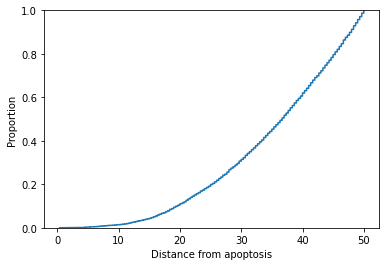

In [284]:
sns.ecdfplot(data=N_events_df_filt, x="Distance from apoptosis")

In [285]:
step = 1 ## difference between temporal bins to plot distance of mitoses from apops
temporal_binned = {}
for time_bin in [(i, i+step) for i in np.arange(t_range[0], t_range[1], step)]:
    temporal_binned[time_bin] = N_events_df_filt.loc[(N_events_df_filt['Time since apoptosis'] >= time_bin[0]) & (N_events_df_filt['Time since apoptosis'] <= time_bin[1])]

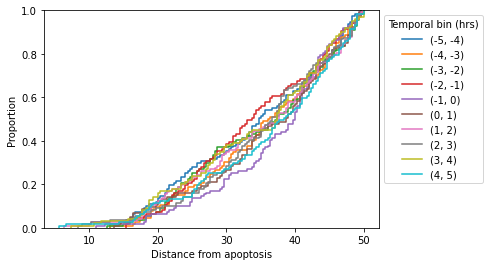

In [290]:
for i in temporal_binned:
    ecdf = sns.ecdfplot(data=temporal_binned[i]['Distance from apoptosis'], label = i)
plt.legend(labels=temporal_binned, title = 'Temporal bin (hrs)', loc = 2,bbox_to_anchor = (1,1))

#### Is there a significant difference between these lines above - needs p test

#### Finally, to confirm the existence of local and transient inhibition, we performed single-cell analysis of cell death probability
by segmenting and tracking the first and the second row of cells
surrounding each dying cell (Figure 2I).

Is this just a radial analysis like I have done?

# Control measures

### 1. Wild-type divisions around random wild-type points

I have some skepticism about this method as it seems too randomised, leading it to pick up some potential boundary effects of scanning in space and time, i.e. it's suspicious that the peaks in probability are repeated in near pre-apoptotic time.

### 2. Wild-type divisions around wild-type apoptoses

Processed

### 3. Wild-type divisions around Scr. apoptoses in uninduced experiments

Need to find Scr. apoptoses in uninduced experiments.

# Loading control measure #1

In [584]:
scan_dir = f'/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_control_wt_div_xyt/1600.1600'

In [585]:
files = natsorted(glob.glob(f'{scan_dir}/*.csv'))
event_files = [file for file in files if 'N_events' in file]
cell_count_files = [file for file in files if 'N_cells' in file]

In [586]:
len(event_files)

7689

#### temp note: need to change path in function if using typical control

In [591]:
control_N_events_df = load_radial_df(event_files[0:3500],
                                    limit = (300, 150),
                                    crop_amount = 20, 
                                    streamline = True, 
                                   strict_filtering= True) ### N_cells is large so streamlining advised

  0%|          | 0/3500 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 248


In [592]:
control_N_cells_df = load_radial_df(cell_count_files[0:3500],# ) #no filtering
                                    limit = (300, 150),
                            crop_amount = 20, 
                            streamline = True, 
                           strict_filtering= True) ### N_cells is large so streamlining advised

  0%|          | 0/3500 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 248


#### Plotting control #1

Text(0.5, 0, 'Time since apoptoses (hours)')

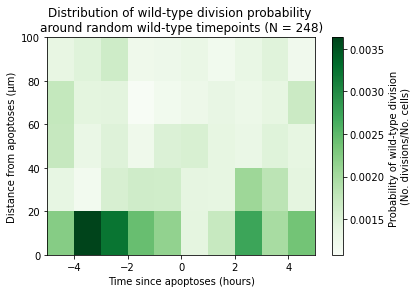

In [440]:
t_range = (-5,5)
R_max = 100
bins = (10, 5)
P_events_c, xedges, yedges,  N_events, N_cells = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events_c.T, cmap = 'Greens', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround random wild-type timepoints (N = 248)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')


#### Plotting probability above background for control #1

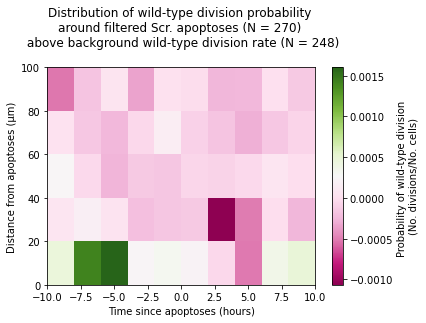

In [441]:
t_range = (-10,10)
R_max = 100
bins = (10, 5)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -10-10hrs.pdf', bbox_inches = 'tight')

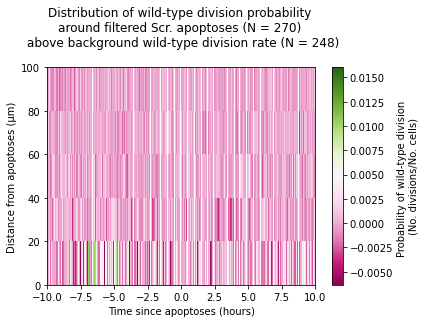

In [442]:
t_range = (-10,10)
R_max = 100
bins = (300, 5)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr/Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -10-10hrs fine grained in time.pdf')

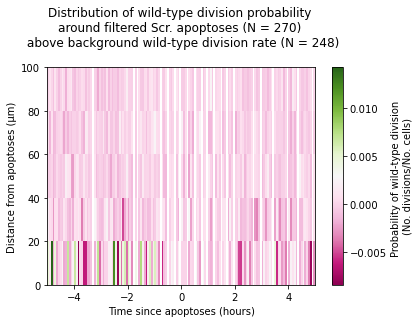

In [443]:
t_range = (-5,5)
R_max = 100
bins = (150, 5)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -5-5hrs finely grained in time.pdf')

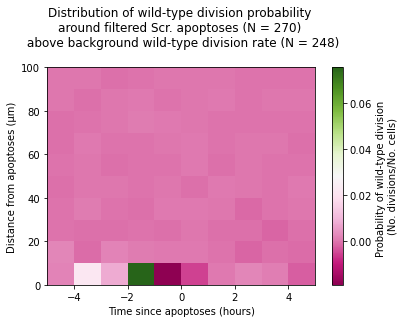

In [444]:
t_range = (-5,5)
R_max = 100
bins = (10, 10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -5-5hrs coarsely grained.pdf')

# Control measure #2 

### Wild-type divisions around wild-type apoptoses

In [667]:
control_2_file_path = '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600'

In [668]:
files = natsorted(glob.glob(f'{control_2_file_path}/*.csv'))
event_files = [file for file in files if 'N_events' in file]
cell_count_files = [file for file in files if 'N_cells' in file]

In [669]:
len(event_files)

385

In [670]:
event_files

['/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600/GV0794_Pos3_wt_142_N_events_wt_rad_1600_t_range_1600_focal_txy_811_447_825.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600/GV0794_Pos3_wt_311_N_events_wt_rad_1600_t_range_1600_focal_txy_731_259_1096.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600/GV0794_Pos4_wt_393_N_events_wt_rad_1600_t_range_1600_focal_txy_766_1173_1456.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600/GV0794_Pos5_wt_1_N_events_wt_rad_1600_t_range_1600_focal_txy_35_274_1395.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600/GV0794_Pos7_wt_292_N_events_wt_rad_1600_t_range_1600_focal_txy_884_447_1576.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/

In [671]:
control_2_N_events_df = load_radial_df(event_files,# ) #no filtering
                                    limit = (300, 150),
                            crop_amount = 20, 
                            streamline = True, 
                           strict_filtering= True) ### N_cells is large so streamlining advised
control_2_N_cells_df = load_radial_df(cell_count_files,# ) #no filtering
                                    limit = (300,150),
                            crop_amount = 20, 
                            streamline = True, 
                           strict_filtering= True) ### N_cells is large so streamlining advised

  0%|          | 0/385 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 51


  0%|          | 0/385 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 51


#### Plotting control #2

# need to replot this as unfiltered in time 300 radius

Text(0.5, 0, 'Time since apoptoses (hours)')

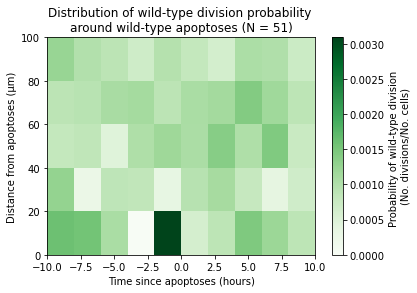

In [672]:
t_range = (-10,10)
R_max = 100
bins = (10, 5)
P_events_c, xedges, yedges,  N_events, N_cells = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events_c.T, cmap = 'Greens', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround wild-type apoptoses (N = 51)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr/wt_apop_wt_div probability cropped 0-100um -10-10hrs.pdf')

#### Plotting probability above background for control #2

Text(0.5, 0, 'Time since apoptoses (hours)')

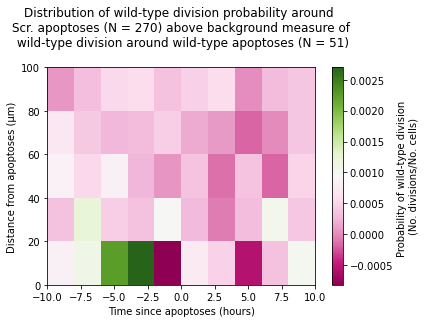

In [459]:
t_range = (-10,10)
R_max = 100
bins = (10, 5)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 270) above background measure of\n wild-type division around wild-type apoptoses (N = 51)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_apop_wt_div cropped 0-100um -10-10hrs.pdf', bbox_inches = 'tight')

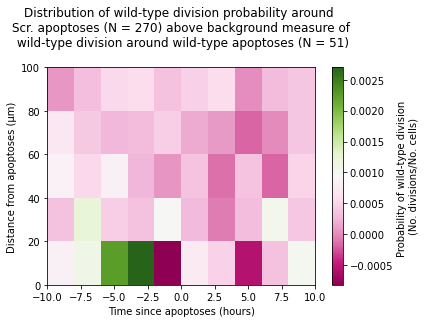

In [460]:
t_range = (-10,10)
R_max = 100
bins = (10, 5)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 270) above background measure of\n wild-type division around wild-type apoptoses (N = 51)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_apop_wt_div cropped 0-100um -10-10hrs.pdf', bbox_inches = 'tight')

Text(0.5, 0, 'Time since apoptoses (hours)')

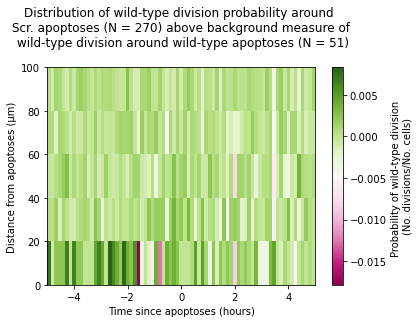

In [673]:
t_range = (-5,5)
R_max = 100
bins = (75,5)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 270) above background measure of\n wild-type division around wild-type apoptoses (N = 51)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_apop_wt_div cropped 0-100um -5-5hrs finely grained in time.pdf', bbox_inches = 'tight')

Text(0.5, 0, 'Time since apoptoses (hours)')

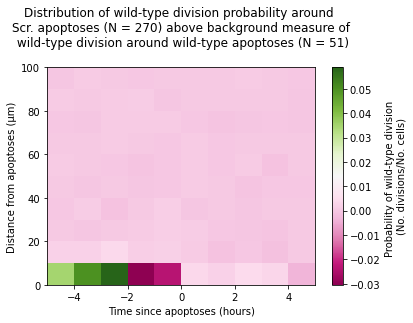

In [674]:
t_range = (-5,5)
R_max = 100
bins = (10,10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 270) above background measure of\n wild-type division around wild-type apoptoses (N = 51)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_apop_wt_div cropped 0-100um -5-5hrs coarse grained.pdf', bbox_inches = 'tight')

# Sandbox

Text(0.5, 0, 'Time since apoptoses (hours)')

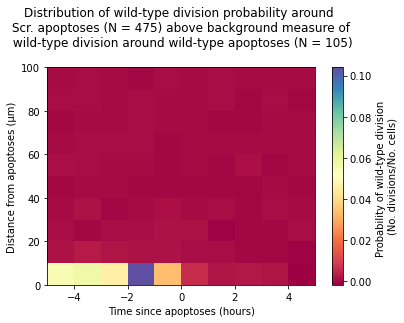

In [135]:
t_range = (-5,5)
R_max = 100
bins = (10,10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'Spectral', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 475) above background measure of\n wild-type division around wild-type apoptoses (N = 105)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

# Coefficient of variation



In [734]:
t_range = (-20,0)
R_max = 100
bins = (10,5)

P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)
#P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_events_df, control_N_cells_df, bins, t_range, R_max)

<Figure size 432x288 with 0 Axes>

In [735]:
cv = np.nan_to_num(np.sqrt((1 - P_events) / (P_events * N_cells)), posinf=1)
# pc = plt.pcolormesh(xedges, yedges, cv.T, cmap = 'Spectral', )
# plt.colorbar(label = 'Coefficient of variation',)
# plt.title('Coefficient of variation for distribution of\n wild-type division probability around \nScr. apoptoses (N = 475)\n ')
# plt.ylabel('Distance from apoptoses (μm)')
# plt.xlabel('Time since apoptoses (hours)')

In [736]:
cv_c = np.nan_to_num(np.sqrt((1 - P_events_c) / (P_events_c * N_cells_c)), posinf=1)
# pc = plt.pcolormesh(xedges, yedges, cv_c.T, cmap = 'Spectral', )
# plt.colorbar(label = 'Coefficient of variation',)
# plt.title('Coefficient of variation for distribution of\n wild-type division probability around \nwild-type apoptoses (N = 105)\n ')
# plt.ylabel('Distance from apoptoses (μm)')
# plt.xlabel('Time since apoptoses (hours)')

Text(0.5, 0, 'Time since apoptoses (hours)')

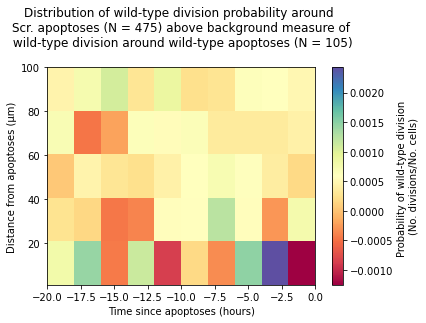

In [737]:
# P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
# P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'Spectral', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 475) above background measure of\n wild-type division around wild-type apoptoses (N = 105)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

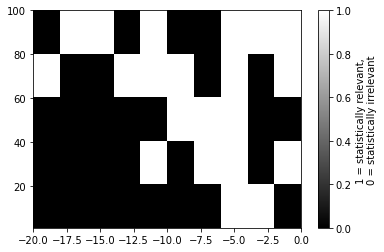

In [738]:
stat_rel = stat_relevance_calc(bins, P_events, P_events_c, cv, cv_c)
pc = plt.pcolormesh(xedges, yedges, stat_rel.T, cmap = 'gray', )
plt.colorbar(label = '1 = statistically relevant, \n0 = statistically irrelevant')

In [635]:
stat_rel.shape

(10, 5)

In [693]:
def stat_relevance_calc(num_bins, P_events, P_events_c, cv, cv_c):
    """
    Function that takes two probability arrays (canon and control), their associated coefficient of variation and calculates the statistical relevance of each bin
    """
    larger_than_array = np.zeros(bins)
    sig_dif_array = np.zeros(bins)
    for i, row in enumerate(P_events):
        for j, element in enumerate(row):
            P_div = P_events[i, j]
            P_div_control = P_events_c[i, j]
            if P_div > P_div_control:
                larger_than_array[i, j] = 1
                measure1 = P_div * (1 - cv[i, j])
                measure2 = P_div_control * (1 + cv_c[i, j])
                if measure1 > measure2:
                    # print(i,j, 'sig dif')
                    sig_dif_array[i, j] = 1
                else:
                    # print(i,j, 'NOT sig dif')
                    sig_dif_array[i, j] = 0
            elif (
                P_div == P_div_control == 0
            ):  ### if P_div is zero then that is bc there arent enough events counted and it is not statistically relevant
                sig_dif_array[i, j] = 0
            elif P_div < P_div_control:
                larger_than_array[i, j] = 0
                measure1 = P_div_control * (1 - cv_c[i, j])
                measure2 = P_div * (1 + cv[i, j])
                if measure1 > measure2:
                    # print(i,j, 'sig dif')
                    sig_dif_array[i, j] = 1
                else:
                    # print(i,j, 'NOT sig dif')
                    sig_dif_array[i, j] = 0
    #         else:
    #             print('Error calculating statistical relevance at index', i,j)
    return sig_dif_array